# EE511 Final Project

In this file we train the SqueezeNet model as described in the paper found [here](https://arxiv.org/abs/1602.07360).
This implementation uses the CIFAR10 dataset.

## Task 1: Train SqueezeNet

For task 1 we train SqueezeNet for 100 epochs and are able to get a final test accuracy of 69.66%.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.ao.quantization import QuantStub, DeQuantStub
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device={device}")

Device=cuda


## Implementation

The class in this cell below defines our architecture and defines our forward pass. We insert quantization stub for later Quantization Aware Training. We also define helper functions to save and load the model.

Note: MSR Initialization was added because the training would not work without it.

In [2]:
import math
class Fire(nn.Module):
    def __init__(self, inplanes, squeeze_planes, expand_planes):
        super(Fire, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=1)
        self.conv3 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

        # # MSR initialization
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
        #         m.weight.data.normal_(0, math.sqrt(2. / n))

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        out1 = self.conv2(x)
        out2 = self.conv3(x)
        out = torch.cat([out1, out2], 1)
        out = self.relu2(out)
        return out

class SqueezeNetCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(SqueezeNetCIFAR10, self).__init__()
        # self.quant = QuantStub()
        # self.dequant = DeQuantStub()

        # self.upsample = nn.Upsample(size=224, mode='bilinear', align_corners=False)

        self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire2 = Fire(96, 16, 64)
        self.fire3 = Fire(128, 16, 64)
        self.fire4 = Fire(128, 32, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire5 = Fire(256, 32, 128)
        self.fire6 = Fire(256, 48, 192)
        self.fire7 = Fire(384, 48, 192)
        self.fire8 = Fire(384, 64, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire9 = Fire(512, 64, 256)
        self.conv10 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.avg_pool = nn.AvgPool2d(13)

    def forward(self, x):
        # x = self.upsample(x)
        # x = self.quant(x)
        x = self.maxpool1(self.conv1(x))

        x = self.fire2(x)
        x = self.fire3(x)
        x = self.fire4(x)
        x = self.maxpool2(x)

        x = self.fire5(x)
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        x = self.maxpool3(x)

        x = self.fire9(x)
        x = self.conv10(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        # x = self.dequant(x)
        return x
    
    def load_model(self, path='squeezenet_fp32.pth',device='cpu'):
        state_dict = torch.load(path,map_location=device)

        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            if k.startswith('module.'):
                k = k[len('module.'):]
            new_state_dict[k] = v

        self.load_state_dict(new_state_dict)
        self.to(device)
        self.eval()

        print(f"Model loaded from {path}")
        # print(self)

    def save_model(self, path='squeezenet_fp32.pth'):
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")


## Load the Dataset

In this cell we define a function to load our dataset.

In [3]:
def load_dataset(path='./data', batch_size=64):
  print("Loading the CIFAR10 dataset")

  transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(), # scale RGB 0-255 to 0-1
    # normalize with known mean and std deviation of the CIFAR10 dataset
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
  ])

  # train_transform = transforms.Compose([
  #   transforms.RandomCrop(32, padding=4),
  #   transforms.RandomHorizontalFlip(),
  #   transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
  #   transforms.ToTensor(),
  #   transforms.Normalize((0.4914, 0.4822, 0.4465),
  #                   (0.2023, 0.1994, 0.2010)),
  # ])
  train_transform = transforms.Compose([
    transforms.Resize(224),  # Resize before any augmentation
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
  ])

  # get training data
  train_dataset = datasets.CIFAR10(root=path, train=True, download=True, transform=train_transform)
  # get test data
  test_dataset = datasets.CIFAR10(root=path, train=False, download=True, transform=transform)
  # load the training data
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=8,pin_memory=True)
  # load the test data
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=8,pin_memory=True)

  print(f"Loaded train data: {len(train_loader.dataset)} total samples, {len(train_loader)} batches\n"
      f"Loaded test data: {len(test_loader.dataset)} total samples, {len(test_loader)} batches")

  return train_loader, test_loader

In [ ]:
train_loader, test_loader = load_dataset(batch_size=128)

## Train the model

In the cells below we define a function to visualize our training and train our model

In [5]:
import matplotlib.pyplot as plt

def plot_metrics(metrics):
  train_losses = metrics.get('train_loss',None)
  test_losses = metrics.get('test_loss',None)
  train_accs = metrics.get('train_acc',None)
  test_accs = metrics.get('test_acc',None)

  epochs = range(1, len(train_losses) + 1)

  plt.figure(figsize=(12, 5))

  # Loss Graph
  plt.subplot(1, 2, 1)
  if train_losses:
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
  if test_losses:
    plt.plot(epochs, test_losses, label='Test Loss', marker='s')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training vs Test Loss')
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6)

  # Accuracy Graph
  plt.subplot(1, 2, 2)
  if train_accs:
    plt.plot(epochs, train_accs, label='Train Accuracy', marker='o')
  if test_accs:
    plt.plot(epochs, test_accs, label='Test Accuracy', marker='s')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.title('Training vs Test Accuracy')
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6)

  plt.tight_layout()
  plt.show()

In [6]:
def train_model(model,train_loader,test_loader,train=True,test=True,device='cpu',epochs=10,lr=1e-3):
  model.to(device)
  metrics = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

  # TRAINING LOOP
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)

  criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
  criterion_test = nn.CrossEntropyLoss()
  # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
  # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


  for e in range(epochs):
    print(f"Epoch [{e+1}/{epochs}] ",end='')
    if train:
      model.train()
      train_loss, total_examples, correct = 0.0, 0, 0

      for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True) # zero gradients
        outputs = model(inputs) # forward pass
        loss = criterion(outputs,labels) # get loss from cost function
        loss.backward() # backward propagation
        optimizer.step() # update gradients

        # train_loss += loss.item() # track total loss up to this point
        train_loss += loss.item() * labels.size(0)
        _, pred_ind = outputs.max(1) # get index of prediction (highest value)
        total_examples += labels.size(0) # update count for this epoch with batch size
        correct += pred_ind.eq(labels).sum().item() # return count of correct predictions

      # scheduler.step() 
    #   train_loss /= len(train_loader) # get average per batch
      train_loss /= total_examples # get average per example
      train_acc = 100.0 * correct / total_examples

      metrics["train_loss"].append(train_loss)
      metrics["train_acc"].append(train_acc)

      print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% ",end='')

      # VALIDATION/TEST
    if test:
      model.eval()
      test_loss, total_examples, correct = 0.0, 0, 0

      with torch.no_grad():
        for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs) # forward pass
          loss = criterion_test(outputs,labels) # get loss from cost function
          test_loss += loss.item() * labels.size(0) # update loss
          _, pred_ind = outputs.max(1) # get index of prediction (highest value)
          total_examples += labels.size(0) # update count for this epoch with batch size
          correct += pred_ind.eq(labels).sum().item() # return count of correct predictions

      test_loss /= total_examples
      test_acc = 100.0 * correct / total_examples

      metrics["test_loss"].append(test_loss)
      metrics["test_acc"].append(test_acc)

      print(f"Test/Val Loss: {test_loss:.4f}, Test/Val Acc: {test_acc:.2f}%")

  return metrics

In [7]:
def init_weights_he(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.zeros_(m.bias)
        
model_fp32 = SqueezeNetCIFAR10()
model_fp32.apply(init_weights_he)
# model_fp32.load_model('squeezenet_fp32.pth')

SqueezeNetCIFAR10(
  (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (fire2): Fire(
    (conv1): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (fire3): Fire(
    (conv1): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (fire4): Fire(
    (conv1): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
    (conv3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (maxpool2): M

In [ ]:
# train, test = True, True
# epochs = 100
# fp32_metrics = train_model(model=model_fp32,train_loader=train_loader,test_loader=test_loader,train=train,test=test,device=device,epochs=epochs)

Epoch [1/100] 

/home1/kodachi/.conda/envs/ee599/lib/python3.12/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 2.5254, Train Acc: 22.35% 

Test/Val Loss: 1.7290, Test/Val Acc: 37.92%
Epoch [2/100] 

Train Loss: 1.9408, Train Acc: 32.23% 

Test/Val Loss: 1.6163, Test/Val Acc: 42.46%
Epoch [3/100] 

Train Loss: 1.8414, Train Acc: 37.60% 

Test/Val Loss: 1.5156, Test/Val Acc: 45.76%
Epoch [4/100] 

Train Loss: 1.7618, Train Acc: 42.05% 

Test/Val Loss: 1.4131, Test/Val Acc: 48.74%
Epoch [5/100] 

Train Loss: 1.7014, Train Acc: 45.46% 

Test/Val Loss: 1.3228, Test/Val Acc: 53.08%
Epoch [6/100] 

Train Loss: 1.6404, Train Acc: 48.22% 

Test/Val Loss: 1.2526, Test/Val Acc: 56.85%
Epoch [7/100] 

Train Loss: 1.5843, Train Acc: 51.62% 

Test/Val Loss: 1.2479, Test/Val Acc: 56.36%
Epoch [8/100] 

Train Loss: 1.5568, Train Acc: 52.95% 

Test/Val Loss: 1.2098, Test/Val Acc: 57.89%
Epoch [9/100] 

Train Loss: 1.5240, Train Acc: 54.67% 

Test/Val Loss: 1.1383, Test/Val Acc: 60.95%
Epoch [10/100] 

Train Loss: 1.5011, Train Acc: 55.77% 

Test/Val Loss: 1.0411, Test/Val Acc: 64.10%
Epoch [11/100] 

Train Loss: 1.4763, Train Acc: 57.16% 

Test/Val Loss: 1.0600, Test/Val Acc: 65.20%
Epoch [12/100] 

Train Loss: 1.4423, Train Acc: 58.88% 

Test/Val Loss: 1.0042, Test/Val Acc: 66.13%
Epoch [13/100] 

Train Loss: 1.4243, Train Acc: 59.80% 

Test/Val Loss: 1.0813, Test/Val Acc: 62.95%
Epoch [14/100] 

Train Loss: 1.4123, Train Acc: 60.32% 

Test/Val Loss: 1.0239, Test/Val Acc: 65.83%
Epoch [15/100] 

Train Loss: 1.3912, Train Acc: 61.86% 

Test/Val Loss: 0.9662, Test/Val Acc: 68.01%
Epoch [16/100] 

Train Loss: 1.3688, Train Acc: 62.68% 

Test/Val Loss: 0.9364, Test/Val Acc: 69.23%
Epoch [17/100] 

Train Loss: 1.3584, Train Acc: 63.31% 

Test/Val Loss: 0.9712, Test/Val Acc: 67.44%
Epoch [18/100] 

Train Loss: 1.3421, Train Acc: 64.04% 

Test/Val Loss: 0.9562, Test/Val Acc: 67.06%
Epoch [19/100] 

Train Loss: 1.3222, Train Acc: 65.15% 

Test/Val Loss: 0.8566, Test/Val Acc: 71.87%
Epoch [20/100] 

Train Loss: 1.3130, Train Acc: 65.80% 

Test/Val Loss: 0.8642, Test/Val Acc: 71.44%
Epoch [21/100] 

Train Loss: 1.3000, Train Acc: 66.33% 

Test/Val Loss: 0.8105, Test/Val Acc: 72.80%
Epoch [22/100] 

Train Loss: 1.2907, Train Acc: 66.77% 

Test/Val Loss: 0.9474, Test/Val Acc: 67.54%
Epoch [23/100] 

Train Loss: 1.2840, Train Acc: 67.09% 

Test/Val Loss: 0.8668, Test/Val Acc: 73.05%
Epoch [24/100] 

Train Loss: 1.2678, Train Acc: 67.78% 

Test/Val Loss: 0.8324, Test/Val Acc: 73.71%
Epoch [25/100] 

Train Loss: 1.2687, Train Acc: 67.90% 

Test/Val Loss: 0.8115, Test/Val Acc: 73.96%
Epoch [26/100] 

Train Loss: 1.2595, Train Acc: 68.66% 

Test/Val Loss: 0.8011, Test/Val Acc: 74.34%
Epoch [27/100] 

Train Loss: 1.2419, Train Acc: 69.32% 

Test/Val Loss: 0.7955, Test/Val Acc: 75.03%
Epoch [28/100] 

Train Loss: 1.2382, Train Acc: 69.64% 

Test/Val Loss: 0.7891, Test/Val Acc: 75.26%
Epoch [29/100] 

Train Loss: 1.2360, Train Acc: 69.50% 

Test/Val Loss: 0.8621, Test/Val Acc: 72.34%
Epoch [30/100] 

Train Loss: 1.2299, Train Acc: 69.99% 

Test/Val Loss: 0.7336, Test/Val Acc: 75.87%
Epoch [31/100] 

Train Loss: 1.2242, Train Acc: 70.29% 

Test/Val Loss: 0.7454, Test/Val Acc: 75.75%
Epoch [32/100] 

Train Loss: 1.2183, Train Acc: 70.54% 

Test/Val Loss: 0.7887, Test/Val Acc: 74.99%
Epoch [33/100] 

Train Loss: 1.2073, Train Acc: 70.97% 

Test/Val Loss: 0.8103, Test/Val Acc: 74.47%
Epoch [34/100] 

Train Loss: 1.2104, Train Acc: 70.94% 

Test/Val Loss: 0.7314, Test/Val Acc: 75.78%
Epoch [35/100] 

Train Loss: 1.2001, Train Acc: 71.33% 

Test/Val Loss: 0.7186, Test/Val Acc: 76.71%
Epoch [36/100] 

Train Loss: 1.1916, Train Acc: 71.81% 

Test/Val Loss: 0.7177, Test/Val Acc: 77.27%
Epoch [37/100] 

Train Loss: 1.1953, Train Acc: 71.56% 

Test/Val Loss: 0.7470, Test/Val Acc: 76.76%
Epoch [38/100] 

Train Loss: 1.1881, Train Acc: 72.00% 

Test/Val Loss: 0.7456, Test/Val Acc: 76.04%
Epoch [39/100] 

Train Loss: 1.1878, Train Acc: 71.84% 

Test/Val Loss: 0.7405, Test/Val Acc: 75.96%
Epoch [40/100] 

Train Loss: 1.1772, Train Acc: 72.66% 

Test/Val Loss: 0.7209, Test/Val Acc: 78.28%
Epoch [41/100] 

Train Loss: 1.1712, Train Acc: 72.89% 

Test/Val Loss: 0.7017, Test/Val Acc: 76.44%
Epoch [42/100] 

Train Loss: 1.1688, Train Acc: 73.17% 

Test/Val Loss: 0.7078, Test/Val Acc: 77.50%
Epoch [43/100] 

Train Loss: 1.1660, Train Acc: 73.03% 

Test/Val Loss: 0.7690, Test/Val Acc: 76.26%
Epoch [44/100] 

Train Loss: 1.1659, Train Acc: 73.23% 

Test/Val Loss: 0.7383, Test/Val Acc: 78.67%
Epoch [45/100] 

Train Loss: 1.1647, Train Acc: 73.07% 

Test/Val Loss: 0.7519, Test/Val Acc: 78.37%
Epoch [46/100] 

Train Loss: 1.1547, Train Acc: 73.73% 

Test/Val Loss: 0.6665, Test/Val Acc: 78.90%
Epoch [47/100] 

Train Loss: 1.1505, Train Acc: 73.73% 

Test/Val Loss: 0.6779, Test/Val Acc: 78.23%
Epoch [48/100] 

Train Loss: 1.1518, Train Acc: 73.76% 

Test/Val Loss: 0.7523, Test/Val Acc: 75.66%
Epoch [49/100] 

Train Loss: 1.1503, Train Acc: 73.80% 

Test/Val Loss: 0.6560, Test/Val Acc: 79.08%
Epoch [50/100] 

Train Loss: 1.1435, Train Acc: 74.01% 

Test/Val Loss: 0.6617, Test/Val Acc: 79.41%
Epoch [51/100] 

Train Loss: 1.1421, Train Acc: 74.23% 

Test/Val Loss: 0.7073, Test/Val Acc: 77.71%
Epoch [52/100] 

Train Loss: 1.1463, Train Acc: 74.09% 

Test/Val Loss: 0.6498, Test/Val Acc: 79.53%
Epoch [53/100] 

Train Loss: 1.1336, Train Acc: 74.94% 

Test/Val Loss: 0.6626, Test/Val Acc: 79.14%
Epoch [54/100] 

Train Loss: 1.1338, Train Acc: 74.89% 

Test/Val Loss: 0.6890, Test/Val Acc: 78.90%
Epoch [55/100] 

Train Loss: 1.1362, Train Acc: 74.38% 

Test/Val Loss: 0.6570, Test/Val Acc: 79.28%
Epoch [56/100] 

Train Loss: 1.1277, Train Acc: 74.93% 

Test/Val Loss: 0.6717, Test/Val Acc: 78.47%
Epoch [57/100] 

Train Loss: 1.1271, Train Acc: 74.95% 

Test/Val Loss: 0.6782, Test/Val Acc: 80.23%
Epoch [58/100] 

Train Loss: 1.1256, Train Acc: 75.29% 

Test/Val Loss: 0.6782, Test/Val Acc: 80.61%
Epoch [59/100] 

Train Loss: 1.1310, Train Acc: 74.73% 

Test/Val Loss: 0.6662, Test/Val Acc: 80.29%
Epoch [60/100] 

Train Loss: 1.1161, Train Acc: 75.48% 

Test/Val Loss: 0.7124, Test/Val Acc: 78.79%
Epoch [61/100] 

Train Loss: 1.1151, Train Acc: 75.63% 

Test/Val Loss: 0.6145, Test/Val Acc: 80.08%
Epoch [62/100] 

Train Loss: 1.1184, Train Acc: 75.68% 

Test/Val Loss: 0.6189, Test/Val Acc: 81.10%
Epoch [63/100] 

Train Loss: 1.1128, Train Acc: 75.50% 

Test/Val Loss: 0.6942, Test/Val Acc: 79.24%
Epoch [64/100] 

Train Loss: 1.1137, Train Acc: 75.50% 

Test/Val Loss: 0.6527, Test/Val Acc: 80.00%
Epoch [65/100] 

Train Loss: 1.1145, Train Acc: 75.63% 

Test/Val Loss: 0.6579, Test/Val Acc: 79.97%
Epoch [66/100] 

Train Loss: 1.1150, Train Acc: 75.61% 

Test/Val Loss: 0.6563, Test/Val Acc: 80.40%
Epoch [67/100] 

Train Loss: 1.1100, Train Acc: 75.48% 

Test/Val Loss: 0.6929, Test/Val Acc: 79.85%
Epoch [68/100] 

Train Loss: 1.1067, Train Acc: 76.06% 

Test/Val Loss: 0.6707, Test/Val Acc: 79.89%
Epoch [69/100] 

Train Loss: 1.1043, Train Acc: 75.99% 

Test/Val Loss: 0.6408, Test/Val Acc: 80.39%
Epoch [70/100] 

Train Loss: 1.1035, Train Acc: 75.97% 

Test/Val Loss: 0.6526, Test/Val Acc: 80.54%
Epoch [71/100] 

Train Loss: 1.1058, Train Acc: 76.07% 

Test/Val Loss: 0.6405, Test/Val Acc: 80.19%
Epoch [72/100] 

Train Loss: 1.1064, Train Acc: 75.94% 

Test/Val Loss: 0.6068, Test/Val Acc: 81.72%
Epoch [73/100] 

Train Loss: 1.1073, Train Acc: 76.05% 

Test/Val Loss: 0.6734, Test/Val Acc: 78.42%
Epoch [74/100] 

Train Loss: 1.0986, Train Acc: 76.42% 

Test/Val Loss: 0.6388, Test/Val Acc: 80.84%
Epoch [75/100] 

Train Loss: 1.1004, Train Acc: 76.22% 

Test/Val Loss: 0.6381, Test/Val Acc: 80.75%
Epoch [76/100] 

Train Loss: 1.0941, Train Acc: 76.60% 

Test/Val Loss: 0.6439, Test/Val Acc: 79.32%
Epoch [77/100] 

Train Loss: 1.1012, Train Acc: 76.18% 

Test/Val Loss: 0.7193, Test/Val Acc: 78.80%
Epoch [78/100] 

Train Loss: 1.0963, Train Acc: 76.41% 

Test/Val Loss: 0.7035, Test/Val Acc: 80.50%
Epoch [79/100] 

Train Loss: 1.0963, Train Acc: 76.56% 

Test/Val Loss: 0.6317, Test/Val Acc: 80.39%
Epoch [80/100] 

Train Loss: 1.0927, Train Acc: 76.73% 

Test/Val Loss: 0.5893, Test/Val Acc: 81.50%
Epoch [81/100] 

Train Loss: 1.0904, Train Acc: 76.81% 

Test/Val Loss: 0.6183, Test/Val Acc: 80.95%
Epoch [82/100] 

Train Loss: 1.0916, Train Acc: 76.74% 

Test/Val Loss: 0.6355, Test/Val Acc: 81.33%
Epoch [83/100] 

Train Loss: 1.0890, Train Acc: 76.95% 

Test/Val Loss: 0.6248, Test/Val Acc: 80.90%
Epoch [84/100] 

Train Loss: 1.0926, Train Acc: 76.73% 

Test/Val Loss: 0.6069, Test/Val Acc: 81.69%
Epoch [85/100] 

Train Loss: 1.0916, Train Acc: 76.65% 

Test/Val Loss: 0.5955, Test/Val Acc: 81.48%
Epoch [86/100] 

Train Loss: 1.0897, Train Acc: 76.87% 

Test/Val Loss: 0.6597, Test/Val Acc: 80.35%
Epoch [87/100] 

Train Loss: 1.0917, Train Acc: 76.76% 

Test/Val Loss: 0.6568, Test/Val Acc: 79.72%
Epoch [88/100] 

Train Loss: 1.0889, Train Acc: 76.80% 

Test/Val Loss: 0.6137, Test/Val Acc: 80.63%
Epoch [89/100] 

Train Loss: 1.0884, Train Acc: 76.86% 

Test/Val Loss: 0.6197, Test/Val Acc: 81.20%
Epoch [90/100] 

Train Loss: 1.0863, Train Acc: 76.86% 

Test/Val Loss: 0.6219, Test/Val Acc: 80.68%
Epoch [91/100] 

Train Loss: 1.0828, Train Acc: 77.22% 

Test/Val Loss: 0.6107, Test/Val Acc: 81.46%
Epoch [92/100] 

Train Loss: 1.0822, Train Acc: 77.10% 

Test/Val Loss: 0.6441, Test/Val Acc: 81.25%
Epoch [93/100] 

Train Loss: 1.0814, Train Acc: 77.26% 

Test/Val Loss: 0.6524, Test/Val Acc: 81.33%
Epoch [94/100] 

Train Loss: 1.0817, Train Acc: 76.98% 

Test/Val Loss: 0.6695, Test/Val Acc: 79.89%
Epoch [95/100] 

Train Loss: 1.0842, Train Acc: 76.89% 

Test/Val Loss: 0.5644, Test/Val Acc: 82.41%
Epoch [96/100] 

Train Loss: 1.0882, Train Acc: 76.98% 

Test/Val Loss: 0.6147, Test/Val Acc: 81.05%
Epoch [97/100] 

Train Loss: 1.0802, Train Acc: 77.34% 

Test/Val Loss: 0.5848, Test/Val Acc: 82.36%
Epoch [98/100] 

Train Loss: 1.0763, Train Acc: 77.49% 

Test/Val Loss: 0.6051, Test/Val Acc: 81.16%
Epoch [99/100] 

Train Loss: 1.0893, Train Acc: 77.02% 

Test/Val Loss: 0.6670, Test/Val Acc: 79.58%
Epoch [100/100] 

Train Loss: 1.0715, Train Acc: 77.63% 

Test/Val Loss: 0.6391, Test/Val Acc: 80.99%


In [ ]:
# model_fp32.save_model("squeezenet_fp32.pth")

Model saved to squeezenet_fp32.pth


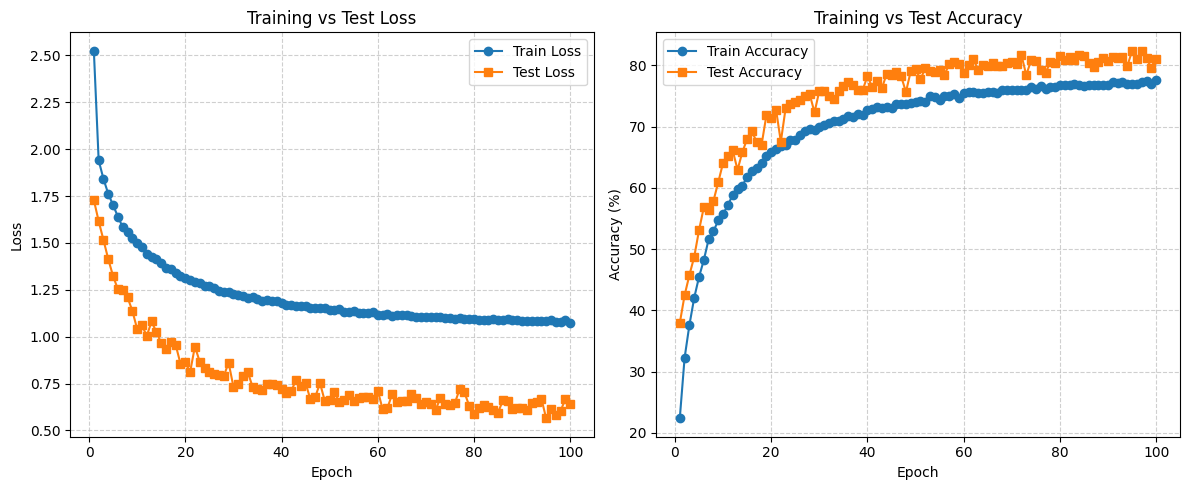

In [ ]:
# plot_metrics(fp32_metrics)

In [11]:
def evaluate(model, test_loader,device='cpu'):
  model.eval()
  model.to(device)
  correct, total = 0, 0

  with torch.no_grad():
      for images, labels in test_loader:
          images = images.to(device, non_blocking=True)
          labels = labels.to(device, non_blocking=True)
          outputs = model(images)
          _, pred = outputs.max(1)
          correct += pred.eq(labels).sum().item()
          total += labels.size(0)

  acc = 100.0 * correct / total
  return acc

In [ ]:
# acc = evaluate(model_fp32,test_loader,device)
# print(f"FP32 Test Accuracy: {acc}%")

FP32 Test Accuracy: 80.99%


## Task 2: Quantize Squeezenet

For task 2 we use quantization aware training to quantize SqueezeNet to INT8. After training for 50 epochs we are able to achieve a final test accuracy of 69.16% with the quantized model.

In [13]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms

# # --------------------------
# # 1) Fixed8_4 Fake Quant Module
# # --------------------------
# class Fixed8_4FakeQuant(nn.Module):
#     """
#     Simulates ap_fixed<8,4>:
#       - 4 integer bits → range: [-8, 7.9375]
#       - 4 fractional bits → scale = 2^4 = 16
#     """
#     def __init__(self):
#         super().__init__()
#         self.scale = 2 ** 4
#         self.min_val = -8.0
#         self.max_val = 7.9375

#     def forward(self, x):
#         scale = torch.tensor(self.scale, device=x.device, dtype=x.dtype)
#         x = torch.clamp(x, self.min_val, self.max_val)
#         x_q = torch.round(x * scale) / scale
#         return x_q

# # --------------------------
# # 2) Quant / DeQuant Stubs
# # --------------------------
# class FixedQuantStub(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fake_quant = Fixed8_4FakeQuant()
#     def forward(self, x):
#         return self.fake_quant(x)

# class FixedDeQuantStub(nn.Module):
#     def forward(self, x):
#         return x  # identity for fake-quant training

# # --------------------------
# # 3) SqueezeNet Wrapper for Fixed QAT
# # --------------------------
# class SqueezeNetFixedQAT(nn.Module):
#     def __init__(self, base_model):
#         super().__init__()
#         self.quant = FixedQuantStub()
#         self.model = base_model
#         self.dequant = FixedDeQuantStub()

#     def forward(self, x):
#         x = self.quant(x)
#         x = self.model(x)
#         x = self.dequant(x)
#         return x

# # --------------------------
# # 4) Activation Quantization (ReLU only)
# # --------------------------
# def apply_activation_q(model):
#     for name, child in list(model.named_children()):
#         apply_activation_q(child)
#         if isinstance(child, nn.ReLU):
#             setattr(model, name, nn.Sequential(child, Fixed8_4FakeQuant()))

# # --------------------------
# # 5) Weight quantization via forward pre-hooks
# # --------------------------
# def add_weight_quant_hooks(model):
#     for name, module in model.named_modules():
#         if isinstance(module, (nn.Conv2d, nn.Linear)):
#             fq = Fixed8_4FakeQuant()
#             def weight_hook(mod, inputs, fq=fq):
#                 mod.weight.data = fq(mod.weight.data)
#             module.register_forward_pre_hook(weight_hook)

# # --------------------------
# # 9) Usage example
# # --------------------------
# # Assume you already have a SqueezeNetCIFAR10 class
# model_fp32 = SqueezeNetCIFAR10()
# model_fp32.load_model("squeezenet_fp32_final.pth")

# model_qat = SqueezeNetFixedQAT(model_fp32)
# apply_activation_q(model_qat.model)   # wrap ReLU activations
# add_weight_quant_hooks(model_qat.model) # weight QAT hooks




In [14]:
import torch
import torch.nn as nn

class Fixed8_4FakeQuant(nn.Module):
    """
    Simulates ap_fixed<8,4>:
      - 4 integer bits → range [-8, 7.9375]
      - 4 fractional bits → scale = 2^4 = 16
    """
    def __init__(self):
        super().__init__()
        self.scale = 2 ** 4
        self.min_val = -8.0
        self.max_val = 7.9375
        self.register_buffer("scale_tensor", torch.tensor(self.scale, dtype=torch.float32))

    def forward(self, x):
        x = torch.clamp(x, self.min_val, self.max_val)
        x_q = torch.round(x * self.scale_tensor) / self.scale_tensor
        return x_q

class FixedQuantStub(nn.Module):
    def __init__(self):
        super().__init__()
        self.fake_quant = Fixed8_4FakeQuant()

    def forward(self, x):
        return self.fake_quant(x)

class FixedDeQuantStub(nn.Module):
    def forward(self, x):
        return x  # identity for fake-quant QAT

def quantize_weights(module):
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        if not hasattr(module, "weight_fp"):
            # Store float copy
            module.weight_fp = nn.Parameter(module.weight.data.clone())
        fq = Fixed8_4FakeQuant()

        # Override forward method temporarily
        orig_forward = module.forward

        def forward_hook(input):
            module.weight.data = fq(module.weight_fp)
            return orig_forward(input)

        module.forward = forward_hook

def apply_activation_q(model):
    for name, child in model.named_children():
        apply_activation_q(child)
        if isinstance(child, nn.ReLU):
            # replace inplace ReLU with non-inplace sequential
            new_relu = nn.Sequential(nn.ReLU(inplace=False), Fixed8_4FakeQuant())
            setattr(model, name, new_relu)

class SqueezeNetFixedQAT(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.quant = FixedQuantStub()
        self.model = base_model
        self.dequant = FixedDeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.model(x)
        x = self.dequant(x)
        return x


In [15]:
model_fp32 = SqueezeNetCIFAR10()
model_fp32.load_model("squeezenet_fp32.pth")
model_qat = SqueezeNetFixedQAT(model_fp32)

# Apply ReLU quantization
apply_activation_q(model_qat.model)

# Apply weight quantization
for m in model_qat.model.modules():
    quantize_weights(m)

Model loaded from squeezenet_fp32.pth


In [16]:
qat_metrics = train_model(model_qat, train_loader, test_loader, device=device, epochs=50)

Epoch [1/50] 

Train Loss: 2.3103, Train Acc: 9.64% 

Test/Val Loss: 2.3061, Test/Val Acc: 8.36%
Epoch [2/50] 

Train Loss: 2.3040, Train Acc: 9.22% 

Test/Val Loss: 2.3049, Test/Val Acc: 8.70%
Epoch [3/50] 

Train Loss: 2.3028, Train Acc: 10.04% 

Test/Val Loss: 2.3039, Test/Val Acc: 9.71%
Epoch [4/50] 

Train Loss: 2.3024, Train Acc: 10.55% 

Test/Val Loss: 2.3034, Test/Val Acc: 8.60%
Epoch [5/50] 

Train Loss: 2.3022, Train Acc: 9.93% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.42%
Epoch [6/50] 

Train Loss: 2.3021, Train Acc: 9.97% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.07%
Epoch [7/50] 

Train Loss: 2.3022, Train Acc: 9.74% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.83%
Epoch [8/50] 

Train Loss: 2.3022, Train Acc: 10.26% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.46%
Epoch [9/50] 

Train Loss: 2.3021, Train Acc: 9.78% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.28%
Epoch [10/50] 

Train Loss: 2.3020, Train Acc: 10.17% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.09%
Epoch [11/50] 

Train Loss: 2.3020, Train Acc: 10.37% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.23%
Epoch [12/50] 

Train Loss: 2.3020, Train Acc: 10.02% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.55%
Epoch [13/50] 

Train Loss: 2.3022, Train Acc: 9.67% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.85%
Epoch [14/50] 

Train Loss: 2.3021, Train Acc: 9.71% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.44%
Epoch [15/50] 

Train Loss: 2.3019, Train Acc: 10.11% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.32%
Epoch [16/50] 

Train Loss: 2.3020, Train Acc: 10.07% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.66%
Epoch [17/50] 

Train Loss: 2.3020, Train Acc: 9.98% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.08%
Epoch [18/50] 

Train Loss: 2.3021, Train Acc: 9.71% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.83%
Epoch [19/50] 

Train Loss: 2.3022, Train Acc: 10.29% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.61%
Epoch [20/50] 

Train Loss: 2.3022, Train Acc: 10.04% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.31%
Epoch [21/50] 

Train Loss: 2.3021, Train Acc: 10.01% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.45%
Epoch [22/50] 

Train Loss: 2.3021, Train Acc: 9.85% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.50%
Epoch [23/50] 

Train Loss: 2.3023, Train Acc: 9.65% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.86%
Epoch [24/50] 

Train Loss: 2.3021, Train Acc: 9.93% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.07%
Epoch [25/50] 

Train Loss: 2.3022, Train Acc: 10.15% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.87%
Epoch [26/50] 

Train Loss: 2.3020, Train Acc: 10.28% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.76%
Epoch [27/50] 

Train Loss: 2.3021, Train Acc: 9.75% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.51%
Epoch [28/50] 

Train Loss: 2.3021, Train Acc: 9.76% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.07%
Epoch [29/50] 

Train Loss: 2.3021, Train Acc: 9.67% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.87%
Epoch [30/50] 

Train Loss: 2.3021, Train Acc: 10.02% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.46%
Epoch [31/50] 

Train Loss: 2.3022, Train Acc: 9.79% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.73%
Epoch [32/50] 

Train Loss: 2.3022, Train Acc: 10.26% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.93%
Epoch [33/50] 

Train Loss: 2.3023, Train Acc: 9.59% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.03%
Epoch [34/50] 

Train Loss: 2.3023, Train Acc: 9.90% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.19%
Epoch [35/50] 

Train Loss: 2.3021, Train Acc: 9.78% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.63%
Epoch [36/50] 

Train Loss: 2.3021, Train Acc: 9.67% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.50%
Epoch [37/50] 

Train Loss: 2.3020, Train Acc: 9.82% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.71%
Epoch [38/50] 

Train Loss: 2.3020, Train Acc: 10.80% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.06%
Epoch [39/50] 

Train Loss: 2.3022, Train Acc: 9.44% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.86%
Epoch [40/50] 

Train Loss: 2.3021, Train Acc: 10.21% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.56%
Epoch [41/50] 

Train Loss: 2.3022, Train Acc: 9.86% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.91%
Epoch [42/50] 

Train Loss: 2.3021, Train Acc: 10.34% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.45%
Epoch [43/50] 

Train Loss: 2.3021, Train Acc: 10.12% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.89%
Epoch [44/50] 

Train Loss: 2.3022, Train Acc: 9.45% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.21%
Epoch [45/50] 

Train Loss: 2.3020, Train Acc: 10.51% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.81%
Epoch [46/50] 

Train Loss: 2.3020, Train Acc: 10.00% 

Test/Val Loss: 2.3032, Test/Val Acc: 8.95%
Epoch [47/50] 

Train Loss: 2.3020, Train Acc: 9.95% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.16%
Epoch [48/50] 

Train Loss: 2.3021, Train Acc: 9.58% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.10%
Epoch [49/50] 

Train Loss: 2.3021, Train Acc: 10.08% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.00%
Epoch [50/50] 

Train Loss: 2.3022, Train Acc: 9.63% 

Test/Val Loss: 2.3032, Test/Val Acc: 9.50%


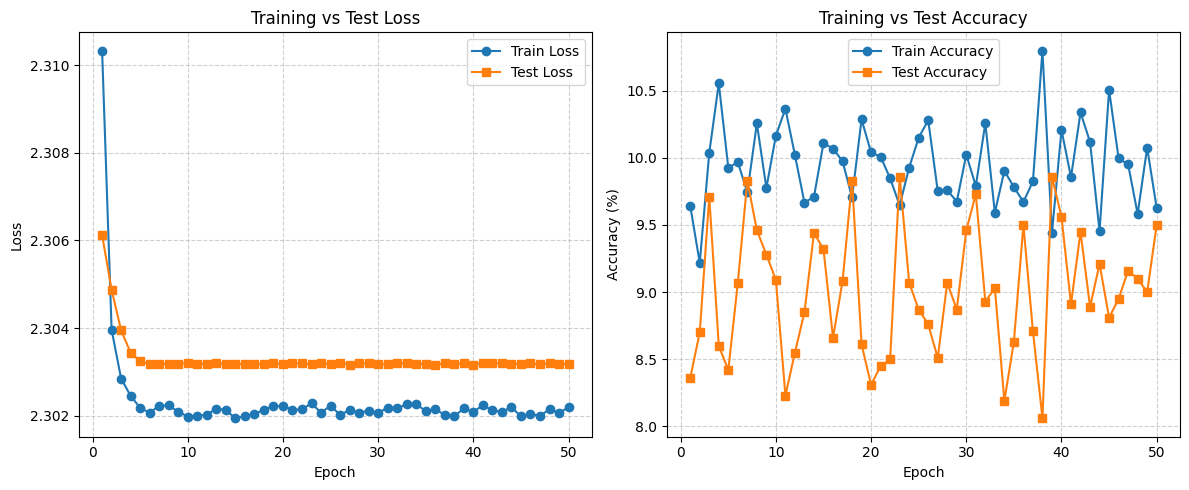

In [17]:
plot_metrics(qat_metrics)

In [18]:
model_qat.eval()
torch.save(model_qat.state_dict(), "squeezenet_stubs.pth")

In [19]:
acc = evaluate(model_qat,test_loader,device)
print(f"FP32 Test Accuracy: {acc}%")

FP32 Test Accuracy: 9.5%
